### Download datasets for this model here:

* https://drive.google.com/drive/folders/19TuTEOKfSOWr4IVf9PrTnN2TQiogoyYV?usp=sharing 

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
import torchvision.transforms as transforms
%matplotlib inline

from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings("ignore")

 ### Here we deifne how to tansform the the data to fit our models
 
 * With the torchvision transformer function
 * We will randomly flip images horisontally for Data augmentaion with we hope to imporve our accuracy
 * We then transform the dataset into a Tensor.
 * Therafter normalize the data.

In [2]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

#### We also have a transform function for our validation set

In [3]:
valid_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

### We define the training and test sets.

* Here we tell torchvision where the data is, then we load in the data with the DataLoader function
* we also split the data into a training set and a test set by using the train perameters, True or false

In [4]:
dataset = torchvision.datasets.CIFAR10(root='datasets/', download=True, transform=ToTensor())

train_set = torchvision.datasets.CIFAR10('./datasets', train=True,
                                         download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10('./datasets', train=False,
                                        download=True, transform=transform)

validation_set = torchvision.datasets.CIFAR10('./datasets', train=False,
                                        download=True, transform=valid_transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=64,
                                           shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64,
                                          shuffle=False, num_workers=4)

validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=64,
                                          shuffle=False, num_workers=4)




Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


### Here we import the Pyplot to assess if the images are loaded correctly or not.

* Importing matplotlip and numpy.
* We define a function to show images from the train_loader dataset
* We create a grid with torchvision and imbed the images into the grid.

In [5]:
len(validation_set), len(test_set), len(train_set)

(10000, 10000, 50000)

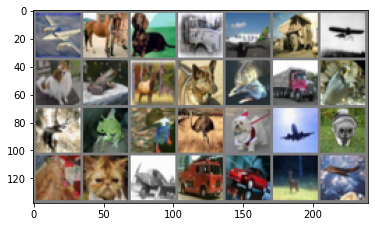

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.show()
    
image_iter = iter(train_loader)
images, _ = image_iter.next()
imshow(torchvision.utils.make_grid(images[:28], nrow=7))

### Check how many images the training and testing datasets contain

In [7]:
dataset_size = len(train_set)
test_dataset_size = len(test_set)

print("Training dataset size", dataset_size)
print("Testing datasets size", test_dataset_size)

print(dataset)


Training dataset size 50000
Testing datasets size 10000
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: datasets/
    Split: Train
    StandardTransform
Transform: ToTensor()


### Get the classes of the entire dataset

In [8]:
classes = dataset.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

### Get the Shapes of the images

In [9]:
img, label = dataset[0]
img_shape = img.shape
img_shape

torch.Size([3, 32, 32])

### Print a sample image

Label (numeric): 6
Label (textual): frog


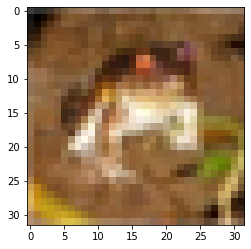

In [10]:
img, label = dataset[0]
plt.imshow(img.permute((1, 2, 0)))
print('Label (numeric):', label)
print('Label (textual):', classes[label])

### Here we determine the number of images belonging to each class?

* We define the length of the dataset
* We then check hoe many classes there are
* We create a dictionary to store the values
* we then do 2 for loops, first to get the classes and the second to count the amount of images retaining to the classes 

In [11]:
dataset_size = len(dataset)
classes = dataset.classes
num_classes = len(dataset.classes)

img_dict = {}
for i in range(num_classes):
    img_dict[classes[i]] = 0
    
for i in range(dataset_size):
    img, label = dataset[i]
    img_dict[classes[label]] += 1

img_dict

{'airplane': 5000,
 'automobile': 5000,
 'bird': 5000,
 'cat': 5000,
 'deer': 5000,
 'dog': 5000,
 'frog': 5000,
 'horse': 5000,
 'ship': 5000,
 'truck': 5000}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


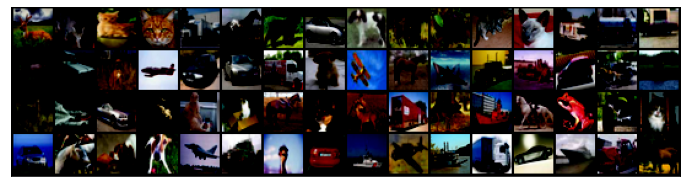

In [12]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

show_batch(train_loader)

### Here we are creating the functionality for calculating the models accuracy

* Todo = Find out how this function works

In [13]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

### ImageClassificationBase contains 4 functions
* One function is for training and validation sets, which implement the loss and accuracy.
* The validation_epoch_end combines the losses and accuracy for each epock 
* The epoch_end prints the val_lass and val_acc at the end of each epoch

In [26]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        print(batch)
        images, labels = batch 
        print(images, labels)

        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['train_loss'], result['val_loss'], result['val_acc']))

##### nn.Sequential chains the layres and activation functions into a single network architecture

In [27]:
class Cifar10CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [28]:
print(Cifar10CnnModel)

<class '__main__.Cifar10CnnModel'>


### Here we move our model to GPU if it can run it

In [29]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        print("Model will run on, GPU")
        return torch.device('cuda')
    else:
        print("Model will run on, CPU")
        return torch.device('cpu')


In [30]:
device = get_default_device()
device

Model will run on, GPU


device(type='cuda')

#### Here we load the data into the GPU device

In [31]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [32]:
train_loader = DeviceDataLoader(train_loader, device)
validation_loader = DeviceDataLoader(validation_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [33]:
model = Cifar10CnnModel()
model

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_feat

In [34]:
model = to_device(model, device)

### The fit function records the validation loss and metric from each epoch. It returns a history of the training, useful for debugging & visualization.

In [35]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

# def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.Adam):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [36]:
history = [evaluate(model, validation_loader)]
history

Streaming output truncated to the last 5000 lines.
        [[[ 0.9608,  0.9922,  0.9765,  ...,  0.9686,  0.9843,  0.9843],
          [ 0.9922,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 0.9686,  1.0000,  0.9922,  ...,  0.9608,  0.9843,  0.9922],
          ...,
          [ 0.9765,  1.0000,  1.0000,  ...,  0.4902,  0.2549,  0.0196],
          [ 0.9765,  1.0000,  1.0000,  ...,  0.3725,  0.4275,  0.1137],
          [ 0.9765,  1.0000,  1.0000,  ...,  0.6157,  0.4902,  0.4275]],

         [[ 0.9608,  0.9922,  0.9765,  ...,  0.9843,  0.9843,  0.9843],
          [ 0.9922,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 0.9686,  1.0000,  0.9922,  ...,  0.9686,  0.9922,  0.9922],
          ...,
          [ 0.9765,  1.0000,  1.0000,  ...,  0.7569,  0.5059,  0.1843],
          [ 0.9765,  1.0000,  1.0000,  ...,  0.5686,  0.6157,  0.2314],
          [ 0.9765,  1.0000,  1.0000,  ...,  0.7098,  0.5922,  0.4824]],

         [[ 0.9608,  0.9922,  0.9765,  ...,  0.9843

[{'val_acc': 0.09952229261398315, 'val_loss': 2.3029778003692627}]

### Here we define the input and output size

In [37]:
input_size = 3*32*32
output_size = 10

### Number of epochs to cycle through and the learning rate is set here

In [38]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

### The fit function will record validation loss and metrics for each epoch

In [39]:
history += fit(num_epochs, lr, model, train_loader, validation_loader, opt_func)

Streaming output truncated to the last 5000 lines.
          [ 0.9922,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 0.9686,  1.0000,  0.9922,  ...,  0.9608,  0.9843,  0.9922],
          ...,
          [ 0.9765,  1.0000,  1.0000,  ...,  0.4902,  0.2549,  0.0196],
          [ 0.9765,  1.0000,  1.0000,  ...,  0.3725,  0.4275,  0.1137],
          [ 0.9765,  1.0000,  1.0000,  ...,  0.6157,  0.4902,  0.4275]],

         [[ 0.9608,  0.9922,  0.9765,  ...,  0.9843,  0.9843,  0.9843],
          [ 0.9922,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 0.9686,  1.0000,  0.9922,  ...,  0.9686,  0.9922,  0.9922],
          ...,
          [ 0.9765,  1.0000,  1.0000,  ...,  0.7569,  0.5059,  0.1843],
          [ 0.9765,  1.0000,  1.0000,  ...,  0.5686,  0.6157,  0.2314],
          [ 0.9765,  1.0000,  1.0000,  ...,  0.7098,  0.5922,  0.4824]],

         [[ 0.9608,  0.9922,  0.9765,  ...,  0.9843,  0.9686,  0.9529],
          [ 0.9922,  1.0000,  1.0000,  ...,  1.0000

### These functions will plot the losses and accuracy of the history i.e. the training

In [40]:
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');
    
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs'); 

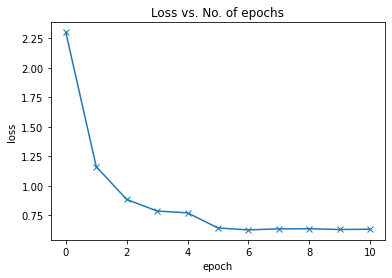

In [41]:
plot_losses(history)

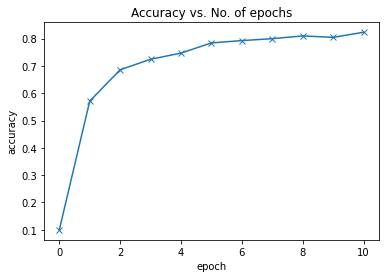

In [42]:
plot_accuracies(history)

### this function will plot will plott the loss difference between the validation set and the training setmm

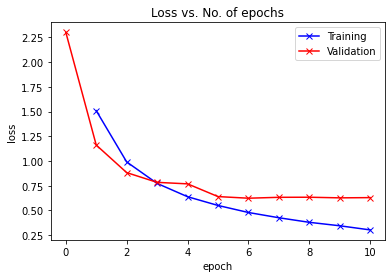

In [43]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    
plot_losses(history);

### Get the accuraccy results for each class

In [44]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
y_actual = []
y_pred = []
confusion_matrix = np.zeros([10,10], int)

# again no gradients needed
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1
            y_actual.append(label.item())
            y_pred.append(prediction.item())
        for i, l in enumerate(labels):
            confusion_matrix[l.item(), predictions[i].item()] += 1 

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class airplane is: 89.1 %
Accuracy for class automobile is: 88.1 %
Accuracy for class bird  is: 67.7 %
Accuracy for class cat   is: 69.4 %
Accuracy for class deer  is: 83.4 %
Accuracy for class dog   is: 71.4 %
Accuracy for class frog  is: 85.3 %
Accuracy for class horse is: 83.9 %
Accuracy for class ship  is: 88.3 %
Accuracy for class truck is: 91.8 %


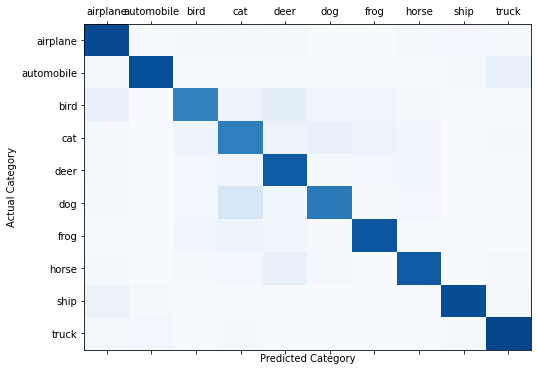

In [45]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
plt.ylabel('Actual Category')
plt.yticks(range(10), classes)
plt.xlabel('Predicted Category')
plt.xticks(range(10), classes)
plt.show()

In [46]:
print('actual/pred'.ljust(16), end='')
for i,c in enumerate(classes):
    print(c.ljust(10), end='')
print()
for i,r in enumerate(confusion_matrix):
    print(classes[i].ljust(16), end='')
    for idx, p in enumerate(r):
        print(str(p).ljust(10), end='')
    print()
    r = r/np.sum(r)
    print(''.ljust(16), end='')
    for idx, p in enumerate(r):
        print(str(p).ljust(10), end='')
    print()

actual/pred     airplane  automobilebird      cat       deer      dog       frog      horse     ship      truck     
airplane        891       6         14        19        13        2         3         8         31        13        
                0.891     0.006     0.014     0.019     0.013     0.002     0.003     0.008     0.031     0.013     
automobile      20        881       2         5         2         2         2         0         9         77        
                0.02      0.881     0.002     0.005     0.002     0.002     0.002     0.0       0.009     0.077     
bird            77        0         677       59        89        34        34        21        7         2         
                0.077     0.0       0.677     0.059     0.089     0.034     0.034     0.021     0.007     0.002     
cat             20        2         47        694       61        76        50        36        3         11        
                0.02      0.002     0.047     0.694     0.061   

In [47]:
TP = 0
FP = 0
FN = 0

for i,r in enumerate(confusion_matrix):
    total = 0
    thisTP = 0
    thisFN = 0
    thisFP = 0 
    for i3 in range (0,10):
        if (i != i3):
            thisFP += confusion_matrix[i3][i]
    for i2,r2 in enumerate(r):
        total += r2
        if (i == i2):
            thisTP += r2
        else:
            thisFN += r2
    
    print(classes[i])
    print('True positives %d' % (thisTP))
    print('False positives %d' % (thisFP))
    print('False negatives %d' % (thisFN))
    precision = thisTP / (thisTP + thisFP)
    recall = thisTP / (thisTP + thisFN)
    print('Precicion {}'.format(precision))
    print('Recall {}'.format(recall))
    f1 = (2 * (precision*recall)) / (precision + recall)
    print('F1 {}'.format(f1))

airplane
True positives 891
False positives 250
False negatives 109
Precicion 0.7808939526730938
Recall 0.891
F1 0.8323213451658105
automobile
True positives 881
False positives 51
False negatives 119
Precicion 0.9452789699570815
Recall 0.881
F1 0.9120082815734989
bird
True positives 677
False positives 173
False negatives 323
Precicion 0.7964705882352942
Recall 0.677
F1 0.7318918918918921
cat
True positives 694
False positives 380
False negatives 306
Precicion 0.6461824953445066
Recall 0.694
F1 0.6692381870781099
deer
True positives 834
False positives 321
False negatives 166
Precicion 0.7220779220779221
Recall 0.834
F1 0.774013921113689
dog
True positives 714
False positives 150
False negatives 286
Precicion 0.8263888888888888
Recall 0.714
F1 0.7660944206008583
frog
True positives 853
False positives 138
False negatives 147
Precicion 0.8607467204843592
Recall 0.853
F1 0.8568558513309893
horse
True positives 839
False positives 144
False negatives 161
Precicion 0.8535096642929807
Reca

In [48]:
from sklearn.metrics import matthews_corrcoef
matthews_corrcoef(y_actual, y_pred)

0.7986688207053414

In [49]:
from sklearn.metrics import classification_report
print(classification_report(y_actual, y_pred, target_names=classes))

              precision    recall  f1-score   support

    airplane       0.78      0.89      0.83      1000
  automobile       0.95      0.88      0.91      1000
        bird       0.80      0.68      0.73      1000
         cat       0.65      0.69      0.67      1000
        deer       0.72      0.83      0.77      1000
         dog       0.83      0.71      0.77      1000
        frog       0.86      0.85      0.86      1000
       horse       0.85      0.84      0.85      1000
        ship       0.93      0.88      0.90      1000
       truck       0.87      0.92      0.89      1000

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000



In [50]:
from sklearn.metrics import cohen_kappa_score
print(cohen_kappa_score(y_actual, y_pred))

0.7982222222222222


In [51]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [52]:
image_size = 64
data_path = '/content/drive/MyDrive/AAI_Exam/datasets/cifar-10_unseen/cifar10.1_v6_data.npy'
X_train = np.load(data_path)
print(f"Shape of training data: {X_train.shape}")
print(f"Data type: {type(X_train)}")

Shape of training data: (2000, 32, 32, 3)
Data type: <class 'numpy.ndarray'>


In [53]:
print(type(X_train[0][0][0][0]))

<class 'numpy.uint8'>


In [54]:
data = X_train.astype(np.float64)
data = 255 * data
img = data.astype(np.uint8)
X_train = img

In [55]:
print(type(X_train[0][0][0][0]))

<class 'numpy.uint8'>


In [56]:
random_image = random.randint(0, len(X_train))
plt.imshow(X_train[random_image])
plt.title(f"Training example #{random_image}")
plt.axis('off')
plt.show()

NameError: ignored

In [ ]:
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import torch
import torch.nn as nn
from torchvision.utils import make_grid
from torchvision.utils import save_image
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import random
%matplotlib inline
class vaporwaveDataset(Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, X):
        'Initialization'
        self.X = X

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.X)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        image = self.X[index]
        X = self.transform(image)
        return X
        
    transform = T.Compose([
        T.ToPILImage(),
        T.Resize(32),
        T.ToTensor()])

In [ ]:
batch_size = 64
transformed_dataset = vaporwaveDataset(X=X_train)
train_dl = DataLoader(transformed_dataset, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [ ]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid((images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images in dl:
        show_images(images, nmax)
        break

In [ ]:
show_batch(train_dl)

In [ ]:
class croppedDataset(Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, ims):
        'Initialization'
        self.ims = ims

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.ims)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        image = self.ims[index]
        X = self.transform(image)
        return X
        
    transform = T.Compose([
        T.ToPILImage(),
        T.CenterCrop(0.75 * 64),
        T.Resize(32),
        #T.RandomResizedCrop(image_size),
        T.RandomHorizontalFlip(),
        T.ToTensor()])
    
batch_size = 64
cropped_dataset = croppedDataset(ims=X_train)
train_dl = DataLoader(cropped_dataset, batch_size, shuffle=True, num_workers=3, pin_memory=True)
show_batch(train_dl)

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

In [ ]:
img = transformed_dataset[1400]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [ ]:
img = transformed_dataset[1006]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [ ]:
test_loader = DeviceDataLoader(DataLoader(transformed_dataset, batch_size*2), device)
type(test_loader)

# print(model)
result = evaluate(model, transformed_dataset)
result